# Zoo Financial Exploraotry Data Analysis
What is the motivation for conducting this analysis?

# Data Source

Zoo chicks' _cashflow_ 

In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd

user = os.getenv("MYSQL_USER")
password = os.getenv("MYSQL_PASSWORD")
host = "localhost"
database = "zoo"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

## User Registration Date

In [48]:
## user registeration , i.e. account creation, date

query = """
SELECT user_id, min(DATE(CREDTM)) registered
FROM zoo_checkchick2.ACC_USER
GROUP BY user_id
"""

users = pd.read_sql(query, con=engine,
                    dtype=({'registered':'datetime64[ns]'}))
users.describe()

,registered
count,651992
mean,2020-02-18 09:02:58.765383936
min,2018-06-01 00:00:00
25%,2018-11-06 00:00:00
50%,2019-07-30 00:00:00
75%,2021-01-06 00:00:00
max,2025-02-08 00:00:00


In [5]:
# user cohorts by registered year

query = """
SELECT
  year(CREDTM) registered_yr,
  count(*) n_new_user
FROM (
  SELECT
    USER_ID,
    min(CREDTM) AS CREDTM
    FROM zoo_checkchick2.ACC_USER
	GROUP BY USER_ID
) AS foo
  GROUP BY registered_yr
  ORDER BY registered_yr
;
"""

pd.read_sql(query, con=engine)

,registered_yr,n_new_user
0,2018,222820
1,2019,174811
2,2020,90177
3,2021,71313
4,2022,32906
5,2023,34311
6,2024,23866
7,2025,1788


## Cashflow

In [223]:
query = """
SELECT DATE_FORMAT(date, '%%Y-%%m') yyyy_mm,
  COUNT(*) total,
  SUM(is_expense) nbr_expense_entry,
  SUM(is_group) nbr_group_entry
FROM zoo.acc_cashflow
GROUP BY yyyy_mm
"""

df = pd.read_sql(query, con=engine)
df.describe()

,total,nbr_expense_entry,nbr_group_entry
count,170.000000,170.000000,170.000000
mean,207616.941176,194336.658824,32174.147059
std,228406.501617,214520.345511,36185.704552
min,1.000000,0.000000,0.000000
25%,3.000000,3.000000,0.000000
50%,232.500000,170.500000,44.500000
75%,416924.000000,386208.000000,65632.750000
max,841703.000000,818109.000000,102861.000000


_**Observation:**_ low record counts erroneous dates?

/var/folders/mx/2pv6svr934z2z3jpglc18x6w0000gn/T/ipykernel_28387/2752326103.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _.set_xticklabels([label if i % 4 == 0 else '' for i, label in enumerate(df_melted['yyyy_mm'])], rotation=90)


Text(0, 0.5, 'Count')

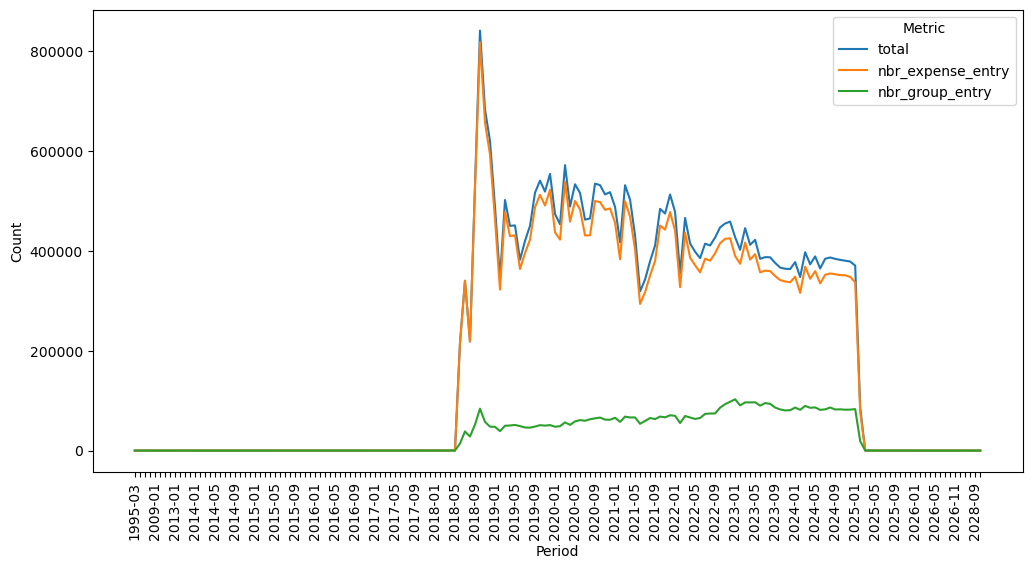

In [229]:
import seaborn as sns

# Reshape data for Seaborn
df_melted = df.melt(id_vars=['yyyy_mm'], var_name='Metric', value_name='Value')
df_melted['yyyy_mm'] = df_melted['yyyy_mm'].astype('string')

_ = sns.lineplot(data=df_melted, x='yyyy_mm', y='Value', color='skyblue', hue='Metric')

# Rotate X-axis labels directly within Seaborn
# Reduce tick labels by selecting every 4th label
_.set_xticklabels([label if i % 4 == 0 else '' for i, label in enumerate(df_melted['yyyy_mm'])], rotation=90)

_.figure.set_size_inches(12, 6)
_.set_xlabel('Period')
_.set_ylabel('Count')
# ax.set_title('Vertical Bar Chart with Rotated Date Labels')

# ax.figure.show()  # Ensure proper display without Matplotlib calls

__*Observation:*__ errorenous timestamps

In [ ]:
# df = cashflow.groupby('yyyy_mm').agg(nbr_expense_entry = ('is_expense', 'sum'),
#                                      nbr_group_entry = ('is_group', 'sum'),
#                                      total = ('yyyy_mm', 'size')
#                                     )


In [89]:
# cashflow dataset
# left and right date range censored to exlude erroneous rows

cashflow = pd.read_sql("SELECT * FROM zoo.acc_cashflow WHERE date BETWEEN '2018-06-01' AND '2025-01-31'",
                       con=engine,
                       dtype={'date':'datetime64[ns]', 'is_expense':'bool', 'is_group':'bool'})
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35205617 entries, 0 to 35205616
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   date         datetime64[ns]
 2   amt          float64       
 3   is_expense   bool          
 4   is_group     bool          
 5   group_id     object        
 6   category_id  int64         
 7   category     object        
 8   note         object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.9+ GB


_**n.b.,**_ __amt__ is float64.

_**Question:**_ Should factional amounts be rounded up?

In [127]:
# should amt be whole number?
bad = cashflow.query("amt % 1 != 0")
bad.describe()

,date,amt,category_id,yyyy,mm
count,130958,1.309580e+05,130958.000000,130958.000000,130958.000000
mean,2022-08-04 07:28:22.109073152,-3.658672e+02,2833.819492,2022.081148,6.648368
min,2018-06-21 00:00:00,-2.222222e+07,0.000000,2018.000000,1.000000
25%,2021-04-14 00:00:00,-4.160000e+01,1.000000,2021.000000,4.000000
50%,2022-11-16 00:00:00,-1.340000e+01,2.000000,2022.000000,7.000000
75%,2024-01-05 00:00:00,-4.152500e+00,5.000000,2024.000000,10.000000
max,2025-01-31 00:00:00,1.000000e+07,75967.000000,2025.000000,12.000000
std,NaN,9.389124e+04,10857.694536,1.654737,3.494182


In [129]:
# create quartile bins
bad.loc[:,'quartile'] = pd.qcut(bad['amt'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
bad.groupby('quartile', observed=True).agg({'amt':['count', 'sum']})

amt              
          count           sum
quartile                     
Q1        32784 -7.720933e+07
Q2        32775 -7.892596e+05
Q3        32659 -2.640294e+05
Q4        32740  3.034938e+07

In [130]:
bad['note'].unique()

array(['食材', '麥當勞', '茶飲料', ..., '1/10薪水', 'myki card賣出', '01/24薪水'],
      shape=(49439,), dtype=object)

In [131]:
bad['category'].unique()

array(['飲食', '日常', '交通', ..., '資源回收', 'IG', '欠瑜'],
      shape=(1435,), dtype=object)

In [132]:
cashflow.isna().sum()

user_id               0
date                  0
amt                   0
is_expense            0
is_group              0
group_id       29755562
category_id           0
category         785454
note                  0
yyyy_mm               0
yyyy                  0
mm                    0
dtype: int64

In [95]:
cashflow.describe()

,date,amt,category_id
count,35205617,3.520562e+07,3.520562e+07
mean,2021-07-31 02:12:30.383510016,2.117972e+02,1.281901e+03
min,2018-06-01 00:00:00,-1.000000e+08,0.000000e+00
25%,2019-12-15 00:00:00,-3.000000e+02,1.000000e+00
50%,2021-06-09 00:00:00,-1.060000e+02,1.000000e+00
75%,2023-03-02 00:00:00,-5.300000e+01,4.000000e+00
max,2025-01-31 00:00:00,1.000000e+08,7.610900e+04
std,NaN,3.898618e+05,6.982359e+03


In [135]:
# Should rows where amount is 0 be excluded?

cashflow[cashflow.amt == 0].count()

user_id        146
date           146
amt            146
is_expense     146
is_group       146
group_id        40
category_id    146
category       112
note           146
yyyy_mm        146
yyyy           146
mm             146
dtype: int64

In [176]:
# check number of active users in each month, i.e. period

cashflow['yyyy_mm'] = pd.to_datetime(cashflow.date).dt.to_period('M')
cashflow['yyyy'] = cashflow['date'].dt.year
cashflow['mm'] = cashflow['date'].dt.month

cashflow.groupby(['yyyy', 'mm']).agg({'user_id':'nunique'}).unstack(level=1)

user_id                                                                 \
mm         1        2        3        4        5        6        7        8    
yyyy                                                                           
2018      NaN      NaN      NaN      NaN      NaN  35697.0  24919.0  13577.0   
2019  26592.0  17247.0  21465.0  18674.0  15526.0  14090.0  27983.0  22929.0   
2020  23356.0  19349.0  18767.0  16541.0  19364.0  17010.0  15178.0  17204.0   
2021  16167.0  16253.0  16303.0  16490.0  15819.0  14809.0  13133.0  14850.0   
2022  16757.0  13230.0  14227.0  12979.0  13316.0  12246.0  12283.0  12179.0   
2023  13364.0  13638.0  13182.0  12242.0  12122.0  11627.0  11620.0  11925.0   
2024  11051.0  11059.0  11270.0  10717.0  10620.0  10370.0  12275.0  10989.0   
2025  10279.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

                                          
mm         9        10       11       12  
yyyy                                      
2018  53552.0  40131.0  39321.0  30287.0  
2019  21412.0  19359.0  19687.0  19899.0  
2020  17793.0  16554.0  15393.0  16349.0  
2021  15803.0  15097.0  14397.0  19462.0  
2022  12737.0  12745.0  12865.0  12748.0  
2023  11901.0  11243.0  11081.0  10469.0  
2024  11095.0  10649.0  10297.0  10073.0  
2025      NaN      NaN      NaN      NaN

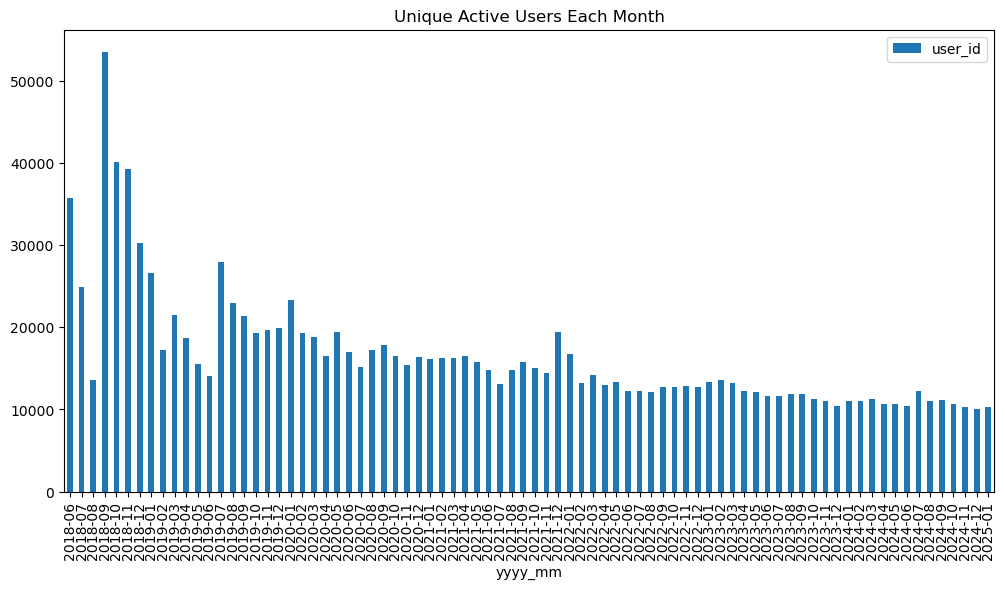

In [21]:
_ = cashflow.groupby('yyyy_mm').agg({'user_id':'nunique'}) \
    .plot(y='user_id', kind='bar', figsize=(12, 6), title="Unique Active Users Each Month")

__*Observation:*__ number of active users gradually declined but not obvious

# Expense by Category
_to-do:_ move under EDA and use _**cashflow**_ instead of calling db

## Private Entry

In [33]:
query = """
SELECT B.CATEGORY,
  count(DISTINCT USER_ID) n_user,
  count(*) nbr_expense,
  round(count(*) / count(DISTINCT USER_ID), 2) nbr_expsense_per_user,  
  round(AVG(AMOUNT)) avg_amt
FROM zoo.ACC_USER_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
    ON A.CATEGORY = B.ID
GROUP BY A.CATEGORY
ORDER BY nbr_expense DESC 
;
"""

pd.read_sql(query, con=engine)

,CATEGORY,n_user,nbr_expense,nbr_expsense_per_user,avg_amt
0,飲食,308559,16104705,52.19,576.0
1,日常,142600,2327199,16.32,1816.0
2,交通,148082,2162896,14.61,1112.0
3,其他,162467,1798762,11.07,3261.0
4,娛樂,121354,1171783,9.66,4674.0
...,...,...,...,...,...
37982,紓困手機,1,1,1.00,5000.0
37983,還淑蕓,1,1,1.00,500.0
37984,油錢（汽,1,1,1.00,1100.0
37985,Irent,1,1,1.00,1153.0


### Group Entry

In [37]:
query = """
SELECT B.CATEGORY,
  count(DISTINCT USER_ID) n_user,
  count(*) nbr_expense,
  round(count(*) / count(DISTINCT USER_ID), 2) nbr_expsense_per_user,  
  round(AVG(AMOUNT)) avg_amt
	FROM zoo_checkchick.ACC_GROUP_DETAIL A
		LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
		ON A.CATEGORY = B.ID
  GROUP BY A.CATEGORY
  ORDER BY nbr_expense DESC
"""

pd.read_sql(query, con=engine)

,CATEGORY,n_user,nbr_expense,nbr_expsense_per_user,avg_amt
0,飲食,40084,2629208,65.59,415.0
1,日常,22282,437774,19.65,2328.0
2,交通,22594,364329,16.13,1122.0
3,其他,22839,277630,12.16,5422.0
4,娛樂,19476,178466,9.16,3628.0
...,...,...,...,...,...
15347,工讀金,1,1,1.00,3600.0
15348,MOD費,1,1,1.00,1199.0
15349,開伙,1,1,1.00,60.0
15350,豆乳❤️,1,1,1.00,99.0


# Tidy Dataset

## Tenure

In [22]:
# user tenure, income and expense entry stats
# n.b. tenure begin when user submit first entry, and does not consider
#      when user first registered with the app

tenure = cashflow.groupby('user_id') \
    .agg(user_tenure = ('date', lambda x: x.max() - x.min()),
         first_entry = ('date', 'min'),
         last_entry = ('date', 'max'),
         nbr_entry = ('user_id', 'count'),
         total_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_exp = ('amt', lambda x: x[x < 0].count()),
         total_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_inc = ('amt', lambda x: x[x > 0].count())
        )

In [23]:
tenure.describe()

,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc
count,399119,399119,399119,399119.000000,3.991190e+05,399119.000000,3.991190e+05,399119.000000
mean,213 days 07:40:33.695213704,2020-01-10 11:45:51.086267392,2020-08-10 19:26:24.781480960,88.207956,-1.266021e+05,82.574220,1.452843e+05,5.633736
min,0 days 00:00:00,2018-06-01 00:00:00,2018-06-03 00:00:00,1.000000,-4.135128e+09,0.000000,0.000000e+00,0.000000
25%,0 days 00:00:00,2018-10-01 00:00:00,2018-12-07 00:00:00,2.000000,-1.603300e+04,2.000000,0.000000e+00,0.000000
50%,7 days 00:00:00,2019-06-29 00:00:00,2019-12-17 00:00:00,7.000000,-2.336000e+03,7.000000,0.000000e+00,0.000000
75%,139 days 00:00:00,2020-10-05 00:00:00,2021-12-12 00:00:00,32.000000,-3.270000e+02,29.000000,9.995000e+03,1.000000
max,2436 days 00:00:00,2025-01-31 00:00:00,2025-01-31 00:00:00,35515.000000,0.000000e+00,25720.000000,5.959085e+09,26923.000000
std,452 days 19:08:00.577961032,NaN,NaN,417.109024,8.975623e+06,382.783317,1.383840e+07,102.548972


_**Initial observation:**_ 25% of users log entries in the last 48~50 days 

In [24]:
cashflow.groupby(['user_id', 'is_group', 'is_expense'])['category_id'].nunique().unstack(level=[1,2], fill_value=0).describe()

is_group            False          True                          False
is_expense          True           True           False          False
count       399119.000000  399119.000000  399119.000000  399119.000000
mean             3.058050       0.525690       0.114364       0.661003
std              2.858143       1.917018       0.637085       1.205456
min              0.000000       0.000000       0.000000       0.000000
25%              1.000000       0.000000       0.000000       0.000000
50%              2.000000       0.000000       0.000000       0.000000
75%              4.000000       0.000000       0.000000       1.000000
max             59.000000      62.000000      43.000000      24.000000

_**Observation:**_ Is it true that entries are not well categorized by the bottom 75% of users?

## Group Entry

In [54]:
# user group expense and income entry stat per user

td_grp = cashflow.query("is_group == True") \
    .groupby('user_id') \
    .agg(n_grp = ('group_id', 'nunique'),
         first_grp_entry = ('date', 'min'),
         last_grp_entry = ('date', 'max'),
         grp_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_grp_exp = ('amt', lambda x: x[x < 0].count()),
         grp_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_grp_inc = ('amt', lambda x: x[x > 0].count())
        )
td_grp.describe()

,n_grp,first_grp_entry,last_grp_entry,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,54842.000000,54842,54842,5.484200e+04,54842.000000,5.484200e+04,54842.000000
mean,1.413242,2021-02-27 17:53:11.174647040,2021-09-02 14:02:35.705481216,-1.510950e+05,92.040863,1.198540e+05,7.335801
min,1.000000,2018-06-01 00:00:00,2018-06-06 00:00:00,-3.000000e+08,0.000000,0.000000e+00,0.000000
25%,1.000000,2019-03-08 00:00:00,2019-09-03 00:00:00,-3.341075e+04,2.000000,0.000000e+00,0.000000
50%,1.000000,2021-01-05 00:00:00,2021-08-25 00:00:00,-4.896500e+03,8.000000,0.000000e+00,0.000000
75%,1.000000,2023-01-01 00:00:00,2023-07-05 00:00:00,-5.230000e+02,44.000000,1.027100e+04,2.000000
max,123.000000,2025-01-31 00:00:00,2025-01-31 00:00:00,0.000000e+00,23868.000000,3.774016e+08,5852.000000
std,1.549848,NaN,NaN,2.186985e+06,363.999029,2.406686e+06,68.584240


## Merge and Impute

In [55]:
td = users.merge(tenure, on='user_id', how='right').merge(td_grp, on='user_id', how='left')
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399119 entries, 0 to 399118
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   user_id          399119 non-null  object         
 1   registered       397402 non-null  datetime64[ns] 
 2   user_tenure      399119 non-null  timedelta64[ns]
 3   first_entry      399119 non-null  datetime64[ns] 
 4   last_entry       399119 non-null  datetime64[ns] 
 5   nbr_entry        399119 non-null  int64          
 6   total_exp        399119 non-null  float64        
 7   nbr_exp          399119 non-null  int64          
 8   total_inc        399119 non-null  float64        
 9   nbr_inc          399119 non-null  int64          
 10  n_grp            54842 non-null   float64        
 11  first_grp_entry  54842 non-null   datetime64[ns] 
 12  last_grp_entry   54842 non-null   datetime64[ns] 
 13  grp_exp          54842 non-null   float64        
 14  nbr_

In [52]:
td.describe()

,registered,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc,n_grp,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,397402,399119,399119,399119,399119.000000,3.991190e+05,399119.000000,3.991190e+05,399119.000000,54842.000000,5.484200e+04,54842.000000,5.484200e+04,54842.000000
mean,2019-11-28 01:43:23.419207680,213 days 07:40:33.695213704,2020-01-10 11:45:51.086267392,2020-08-10 19:26:24.781480960,88.207956,-1.266021e+05,82.574220,1.452843e+05,5.633736,1.413242,-1.510950e+05,92.040863,1.198540e+05,7.335801
min,2018-06-01 00:00:00,0 days 00:00:00,2018-06-01 00:00:00,2018-06-03 00:00:00,1.000000,-4.135128e+09,0.000000,0.000000e+00,0.000000,1.000000,-3.000000e+08,0.000000,0.000000e+00,0.000000
25%,2018-09-25 00:00:00,0 days 00:00:00,2018-10-01 00:00:00,2018-12-07 00:00:00,2.000000,-1.603300e+04,2.000000,0.000000e+00,0.000000,1.000000,-3.341075e+04,2.000000,0.000000e+00,0.000000
50%,2019-03-29 00:00:00,7 days 00:00:00,2019-06-29 00:00:00,2019-12-17 00:00:00,7.000000,-2.336000e+03,7.000000,0.000000e+00,0.000000,1.000000,-4.896500e+03,8.000000,0.000000e+00,0.000000
75%,2020-06-29 00:00:00,139 days 00:00:00,2020-10-05 00:00:00,2021-12-12 00:00:00,32.000000,-3.270000e+02,29.000000,9.995000e+03,1.000000,1.000000,-5.230000e+02,44.000000,1.027100e+04,2.000000
max,2025-02-07 00:00:00,2436 days 00:00:00,2025-01-31 00:00:00,2025-01-31 00:00:00,35515.000000,0.000000e+00,25720.000000,5.959085e+09,26923.000000,123.000000,0.000000e+00,23868.000000,3.774016e+08,5852.000000
std,NaN,452 days 19:08:00.577961032,NaN,NaN,417.109024,8.975623e+06,382.783317,1.383840e+07,102.548972,1.549848,2.186985e+06,363.999029,2.406686e+06,68.584240


1905      0.0
1934      0.0
1962      0.0
1985      0.0
1997      0.0
         ... 
399037    0.0
399041    0.0
399076    0.0
399107    0.0
399116    0.0
Name: grp_inc, Length: 32376, dtype: float64

In [75]:
cashflow.loc[(abs(cashflow.amt) < 1) & (cashflow.amt > 0), 'amt'].mean()

np.float64(0.24052028096932518)

# EDA

In [26]:
# select users having made at least 1 entry in the past 50 days

t1 = max(tenure.last_entry)
t0 = t1 - pd.Timedelta(days=50)

tenure.loc[tenure.last_entry >= t0,]['nbr_entry'].quantile([0.25, 0.5, 0.75])
# td.last_entry >= t0 & td.last_entry < t1 

0.25      60.00
0.50     403.00
0.75    1677.75
Name: nbr_entry, dtype: float64

In [27]:
tenure.loc[tenure.last_entry >= t0,]['nbr_entry'].count()

np.int64(11578)

In [28]:
# group expense and income entry stat per user

td_grp = cashflow.query("is_group == True") \
    .groupby('user_id') \
    .agg(n_grp = ('group_id', 'nunique'),
         grp_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_grp_exp = ('amt', lambda x: x[x < 0].count()),
         grp_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_grp_inc = ('amt', lambda x: x[x > 0].count())
        )
td_grp.describe()

,n_grp,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,54842.000000,5.484200e+04,54842.000000,5.484200e+04,54842.000000
mean,1.413242,-1.510950e+05,92.040863,1.198540e+05,7.335801
std,1.549848,2.186985e+06,363.999029,2.406686e+06,68.584240
min,1.000000,-3.000000e+08,0.000000,0.000000e+00,0.000000
25%,1.000000,-3.341075e+04,2.000000,0.000000e+00,0.000000
50%,1.000000,-4.896500e+03,8.000000,0.000000e+00,0.000000
75%,1.000000,-5.230000e+02,44.000000,1.027100e+04,2.000000
max,123.000000,0.000000e+00,23868.000000,3.774016e+08,5852.000000


... what do you want to say here?

In [29]:
td_grp.head()

,n_grp,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
user_id,,,,,
U00012edc9efabb05d4c4aebcbbb0d04f,2,-5885.00,19,0.0,0
U00017a7f6dbfe5f911a9e0d377fbb1e0,1,-1304.05,12,660.0,6
U0004af0fd753c8f2c87f5e7878bb39a6,1,-67110.47,79,70858.0,35
U0005394a5980e1e2bb82117f66a40685,1,-150.00,1,0.0,0
U0006a568eb5ecb351120b8efef8cf1fb,1,-4896.00,14,6400.0,2


In [30]:
#number of members in each group
nbr_mbr_grp = cashflow.query("is_group == True").groupby('group_id')['user_id'].nunique()

nbr_mbr_grp.agg(['min', 'max', 'mean', 'median'])

min        1.000000
max       61.000000
mean       1.485282
median     1.000000
Name: user_id, dtype: float64

In [31]:
nbr_mbr_grp.quantile([.25, .5, .75, .8, .9, .95, .99])

0.25    1.0
0.50    1.0
0.75    2.0
0.80    2.0
0.90    2.0
0.95    2.0
0.99    3.0
Name: user_id, dtype: float64

## Supplemental

```sql
-- consolidate expense and income entry to simplify analysis

USE zoo;

DROP TABLE IF EXISTS acc_cashflow;

CREATE TABLE acc_cashflow (
	user_id VARCHAR(100) NOT NULL,
  date DATE NOT NULL,
  amt DOUBLE NOT NULL,
  is_expense BOOLEAN,
	is_group BOOLEAN,
  group_id VARCHAR(100),
  category_id INT,
  category VARCHAR(100),
  note VARCHAR(160)
) COMMENT = 'consolidate expense and income entries'
;

-- insert personal expense
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  -AMOUNT amt,
  TRUE is_expense,
	FALSE is_group,
  NULL group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo.ACC_USER_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
ON A.CATEGORY = B.ID
;

-- insert group expense
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  -AMOUNT amt,
  TRUE is_expense,
	TRUE is_group,
  GROUP_ID group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick.ACC_GROUP_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
ON A.CATEGORY = B.ID
;

-- insert personal income
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  AMOUNT amt,
  FALSE is_expense,
	FALSE is_group,
  NULL group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick2.ACC_USER_DETAIL_INCOME A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY_INCOME B
ON A.CATEGORY = B.ID
;

-- insert group income
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  AMOUNT amt,
  FALSE is_expense,
	TRUE is_group,
  GROUP_ID group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick2.ACC_GROUP_DETAIL_INCOME A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY_INCOME B
ON A.CATEGORY = B.ID
;
```